In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt 

# check PyTorch version
torch.__version__

'2.0.1+cu118'

## Data preparing and loading

In [4]:
# Known parameters 
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [19]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [10]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None
):
    """
    Plots training data, test data and compares prediction
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})

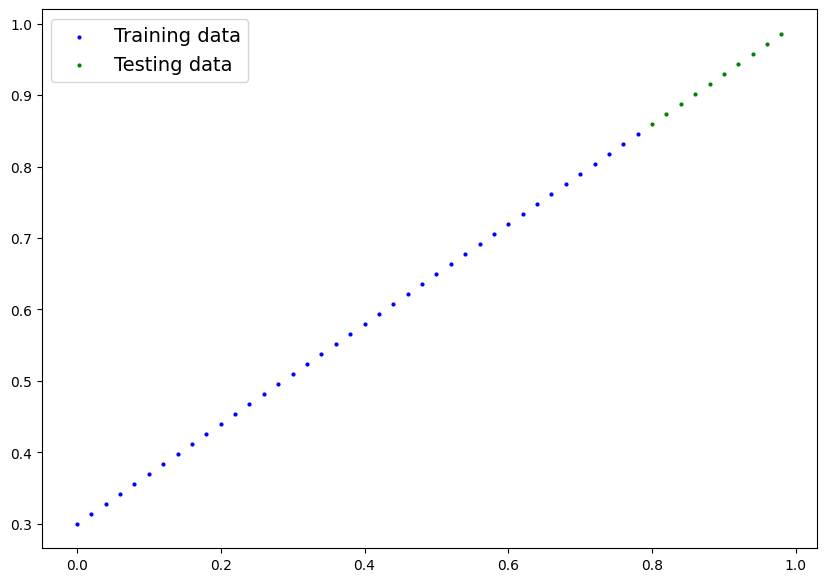

In [11]:
plot_prediction()

## Build first PyTorch model

In [7]:
# Create a linear regression 
class LinearRegressionModel(nn.Module): # <- ALmost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))

    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formular

### PyTorch model building essentials 

In [8]:
import torch 
from torch import nn

In [48]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [40]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions with torch inference mode

In [41]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [42]:
y_test 

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [49]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a training loop in PyTorch

In [50]:
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0. loop through the data
for epoch in range(epochs): 
    model_0.train() # set model to train mode, sets requires_grad to true

    # 1. Forward pass 
    y_pred = model_0(X_train)

    # 2. Calculate the loss 
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Perform backprop on the loss with respect to the params of the mode
    loss.backward()

    # 5. Step the optimizer, perform gradient decent 
    optimizer.step() # optimizer changes will accumulate thorught the loop, so we have to zero them above in step 3 for the next i

    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 140 | Loss: 0.010716589167714119 | Test loss: 0.024059748277068138
Epoch: 160 | Loss: 0.0038517764769494534 | Test loss: 0.008201557211577892
Epoch: 180 | Loss: 0.008932482451200485 | Test loss: 0.005023092031478882


In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5102])), ('bias', tensor([0.3790]))])

In [16]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [17]:
model_0.eval()

LinearRegressionModel()

In [45]:
epoch_count, loss_values, test_loss_values

([0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560],
 [array(0.31288138, dtype=float32),
  array(0.26679736, dtype=float32),
  array(0.2207134, dtype=float32),
  array(0.17462942, dtype=float32),
  array(0.12854603, dtype=float32),
  array(0.08973254, dtype=float32),
  array(0.068288, dtype=float32),
  array(0.05696033, dtype=float32),
  array(0.05105169, dtype=float32),
  array(0.04769856, dtype=float32),
  array(0.04549176, dtype=float32),
  array(0.04381453, dtype=float32),
  array(0.04230218, dtype=float32),
  array(0.04090612, dtype=float32),
  array(0.03951007, dtype=float32)],
 [array(0.49318904, dtype=float32),
  array(0.43930522, dtype=float32),
  array(0.3854214, dtype=float32),
  array(0.33153754, dtype=float32),
  array(0.27765432, dtype=float32),
  array(0.2279584, dtype=float32),
  array(0.18992408, dtype=float32),
  array(0.161748, dtype=float32),
  array(0.14154997, dtype=float32),
  array(0.12709849, dtype=float32),
  array(0.11657621, dtype=float3

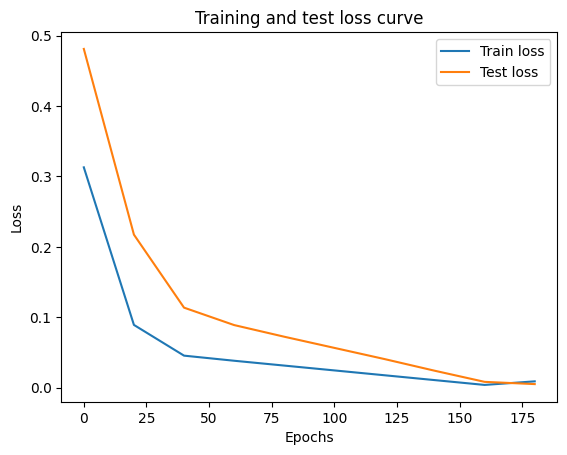

In [51]:
# Plot the loss curves
import matplotlib.pyplot as plt

plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")

plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Saving a model in PyTorch

In [57]:
from pathlib import Path 

# Create model path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save model save dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\01_pytorch_workflow_0.pt


## Loading a PyTorch model

In [58]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [59]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

### Make some predictions with loaded model

In [64]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [65]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [66]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])